# EDA
Here I will explore relationships between the different features in my data.

**imports**

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
import explore_

# other
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)


# set a default them for all my visuals
sns.set_theme(style="whitegrid")

**get data**
 I am using training data. Data was split and saved into a separate file from preparation stage.


In [2]:
# get the training data not encoded
train = pd.read_csv("00_project_data/01_original_clean_no_dummies_train.csv", index_col=0)
train = train.reset_index(drop=True)

In [3]:
train.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,number_of_persons_injured,number_of_pedestrians_injured,number_of_cyclist_injured,number_of_motorist_injured,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,fatality
0,2019-10-19,2023-08-06 04:09:00,bronx,10467,40.866577,-73.867325,0,0,0,0,...,unspecified,unspecified,unspecified,unspecified,car,unknown,unknown,unknown,unknown,0
1,2015-01-24,2023-08-06 15:00:00,queens,11103,40.767964,-73.911682,0,0,0,0,...,unspecified,unspecified,unspecified,unspecified,van,van,unknown,unknown,unknown,0
2,2021-04-07,2023-08-06 17:31:00,queens,11101,40.746185,-73.929490,1,0,0,1,...,unspecified,unspecified,unspecified,unspecified,van,car,unknown,unknown,unknown,0
3,2014-08-04,2023-08-06 11:00:00,brooklyn,11213,40.668506,-73.925605,0,0,0,0,...,unspecified,unspecified,unspecified,unspecified,car,unknown,unknown,unknown,unknown,0
4,2012-10-02,2023-08-06 16:40:00,brooklyn,11221,40.686346,-73.923397,1,1,0,0,...,unspecified,unspecified,unspecified,unspecified,car,unknown,unknown,unknown,unknown,0


## Univariate

#### What is the overall trend of the number of crashes over time (based on 'crash_date' and 'crash_time')?

In [4]:
# Convert column datatype to datetime
train.crash_date = train.crash_date.astype("datetime64")
train.crash_time = train.crash_time.astype("datetime64")

In [5]:
# resample by sum of day
day_resample_df = train.resample("D", on='crash_date').sum()
day_resample_df.head(3)

,latitude,longitude,number_of_persons_injured,number_of_pedestrians_injured,number_of_cyclist_injured,number_of_motorist_injured,fatality
crash_date,,,,,,,
2012-07-01,10627.056157,-19296.621889,76,13,7,56,0
2012-07-02,11239.887143,-20404.844025,79,16,16,47,1
2012-07-03,13114.056234,-23805.687282,101,23,8,70,1


In [6]:
# get columns fot he day rasample
day_resample_cols = day_resample_df.columns[~day_resample_df.columns.isin(["latitude", "longitude"])]
day_resample_cols

Index(['number_of_persons_injured', 'number_of_pedestrians_injured',
       'number_of_cyclist_injured', 'number_of_motorist_injured', 'fatality'],
      dtype='object')

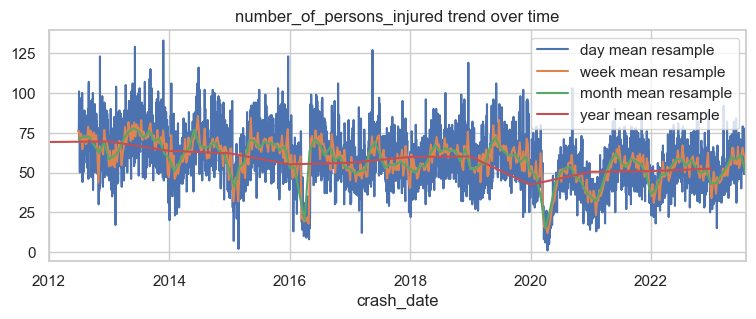

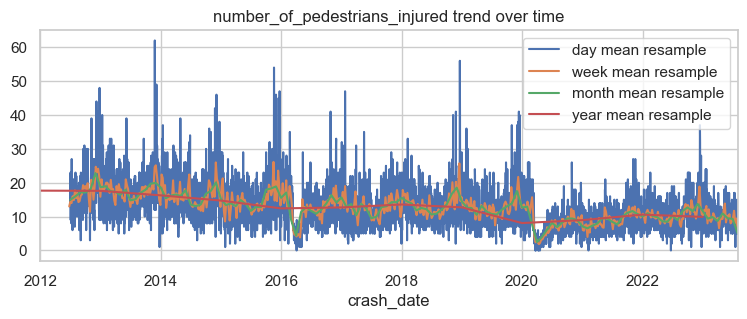

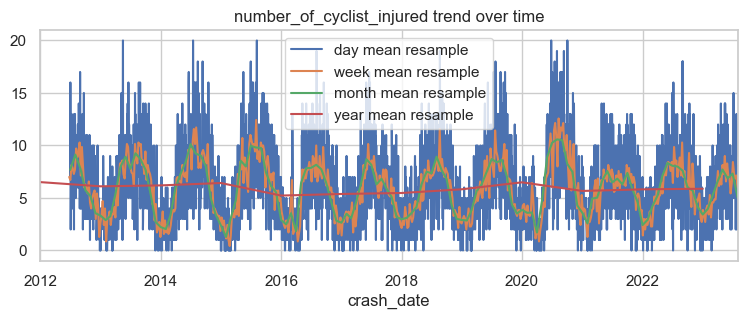

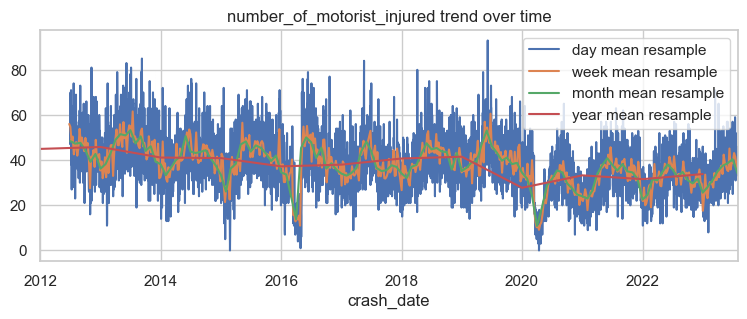

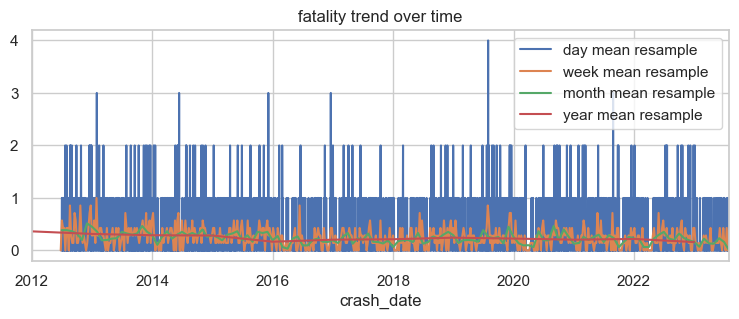

In [7]:
# Plot trend over time
for i in day_resample_cols:
    plt.figure(figsize=(9,3))
    day_resample_df.resample("D")[i].mean().plot(label="day mean resample")
    day_resample_df.resample("W")[i].mean().plot(label="week mean resample")
    day_resample_df.resample("M")[i].mean().plot(label="month mean resample")
    day_resample_df.resample("Y")[i].mean().plot(label="year mean resample")
    plt.title(f"{i} trend over time")
    plt.legend()
    # save the generated visual to folder
    explore_.save_visuals(fig= plt.gcf() ,viz_name= "f{i}_trend_over_time", folder_name= 1)
    plt.show()

- Sesonal trend found in number of motorists, cyclists, and personel ingired. look to not have a strong seasonal trend in the number of pedestrins ingired and in fatalities.

#### Which borough has the highest number of crashes, and which has the lowest?

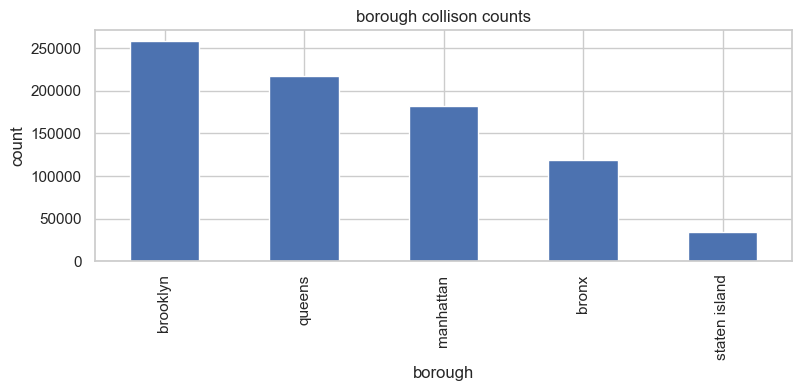

In [8]:
# Plot borough counts
plt.figure(figsize=(9,3))
train.borough.value_counts().plot.bar()
plt.title("borough collison counts")
plt.xlabel("borough")
plt.ylabel("count")
# save the generated visual to folder
explore_.save_visuals(fig= plt.gcf(), viz_name= "borough_collison_counts", folder_name= 1)
plt.show()

- Brooklyn has the highest number of collisons (250,000) and staten island has the lowest count (about 30,000).

**Are there any specific zip codes that experience a higher number of crashes?**

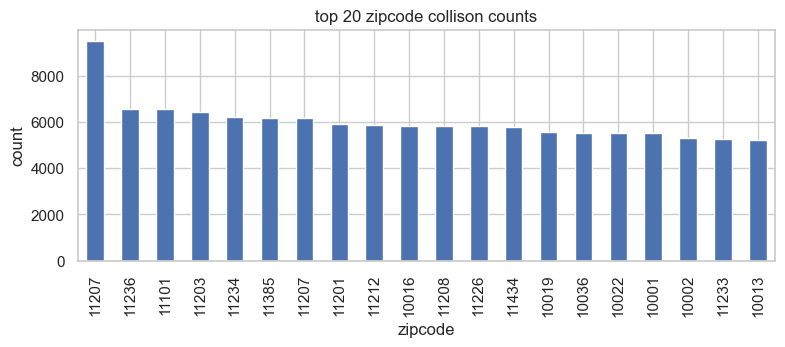

In [9]:
# Plot borough counts
plt.figure(figsize=(9,3))
train.zip_code.value_counts()[train.zip_code.value_counts() > 5000].plot.bar()
plt.title("top 20 zipcode collison counts")
plt.xlabel("zipcode")
plt.ylabel("count")
# save the generated visual to folder
explore_.save_visuals(fig= plt.gcf(), viz_name= "zipcode_collison_counts", folder_name= 1)
plt.show()

- zipcode 11207 has the highest number of collisons.

#### What are the most common contributing factors to crashes?

In [10]:
# select only the contributing factor columns
contributing_factor = train.columns[train.columns.str.contains("factor")]
contributing_factor

Index(['contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'contributing_factor_vehicle_3', 'contributing_factor_vehicle_4',
       'contributing_factor_vehicle_5'],
      dtype='object')

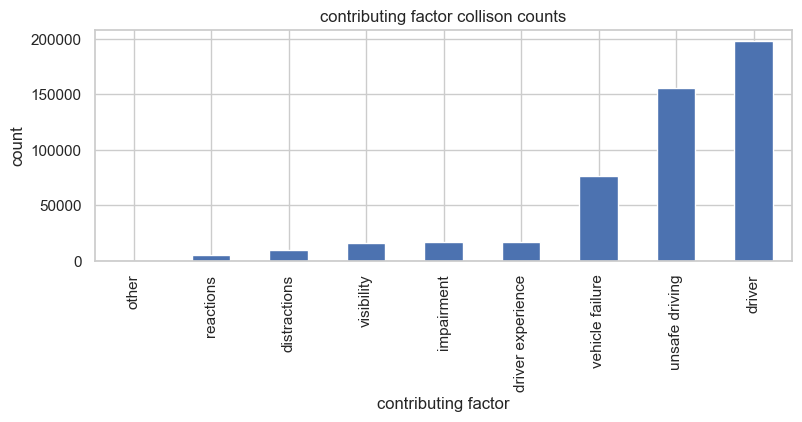

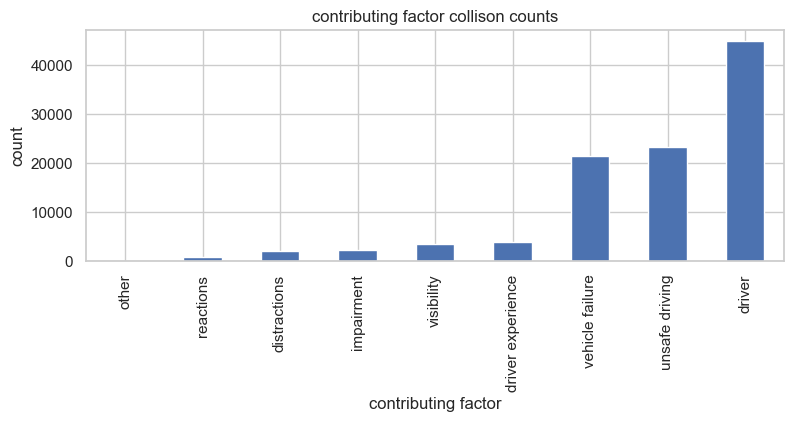

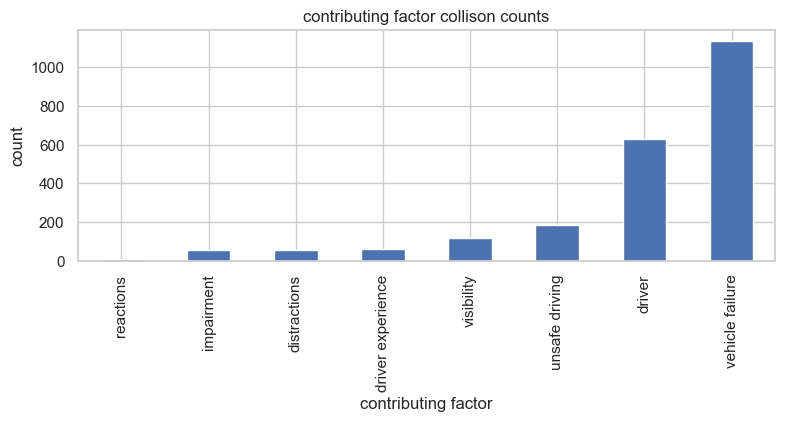

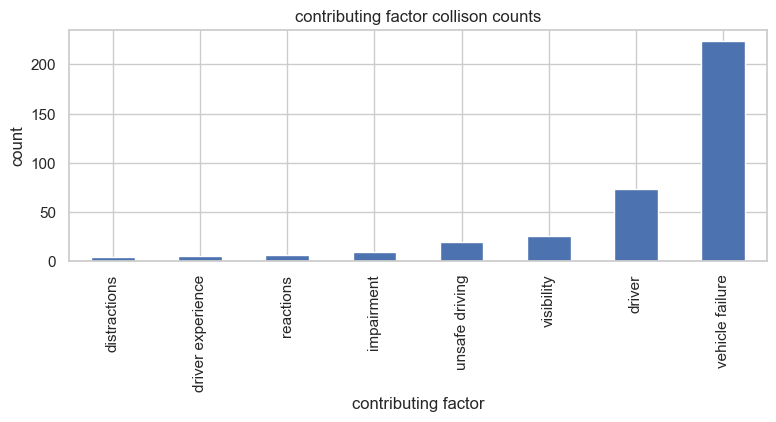

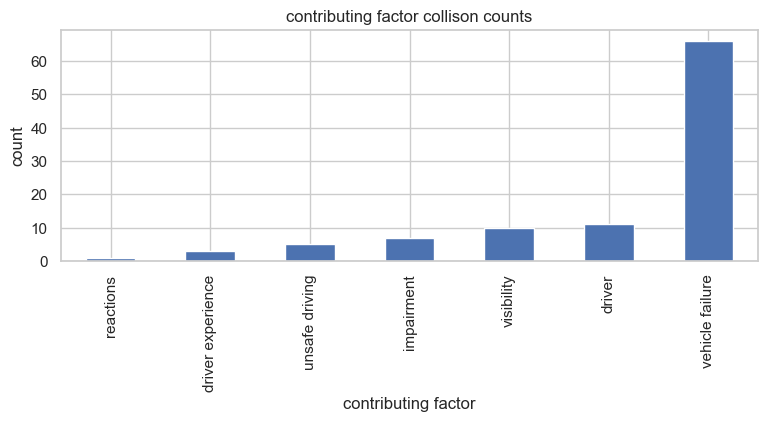

In [11]:
# plot contributing factors
for i in contributing_factor:
    plt.figure(figsize=(9,3))
    train[i].value_counts().sort_values()[:-1].plot.bar() # remove unkowns
    plt.title("contributing factor collison counts")
    plt.xlabel("contributing factor")
    plt.ylabel("count")
    # save the generated visual to folder
    explore_.save_visuals(fig= plt.gcf(), viz_name= "contributing_factor_collison_counts", folder_name= 1)
    plt.show()

- The most common contributing factors for crashes are driver distraction, unface driving, and vehicle failure.

#### What types of vehicles are involved in the most crashes?

In [12]:
# select only the types of vehicles columns
types_of_vehicles = train.columns[train.columns.str.contains("type")]
types_of_vehicles

Index(['vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3',
       'vehicle_type_code_4', 'vehicle_type_code_5'],
      dtype='object')

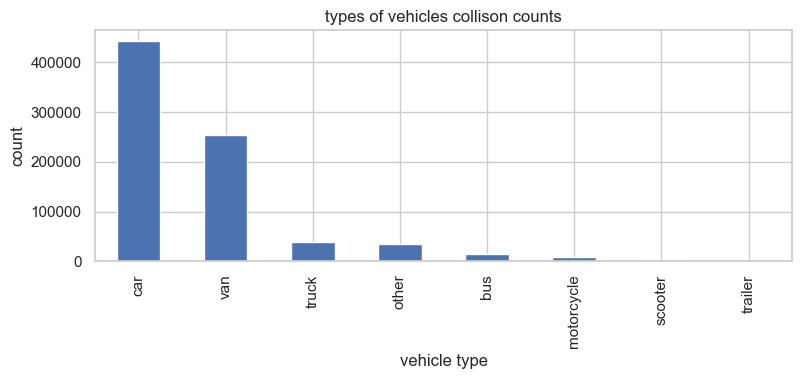

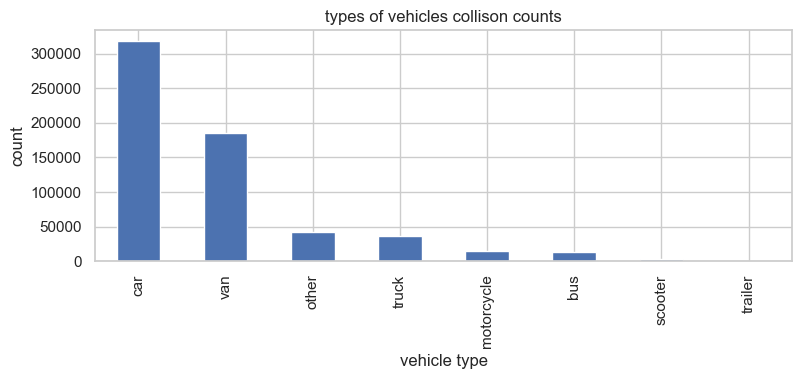

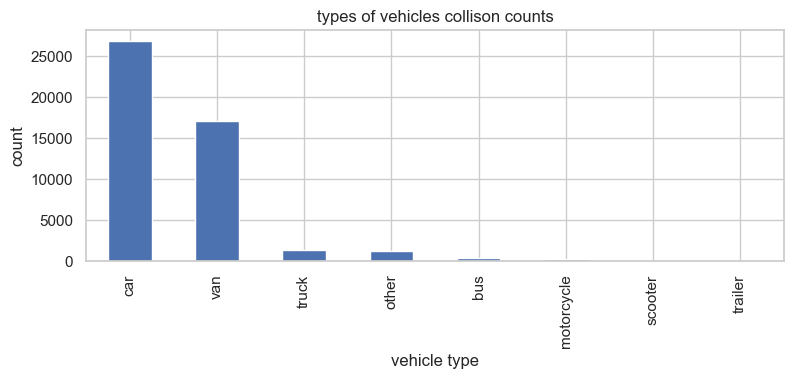

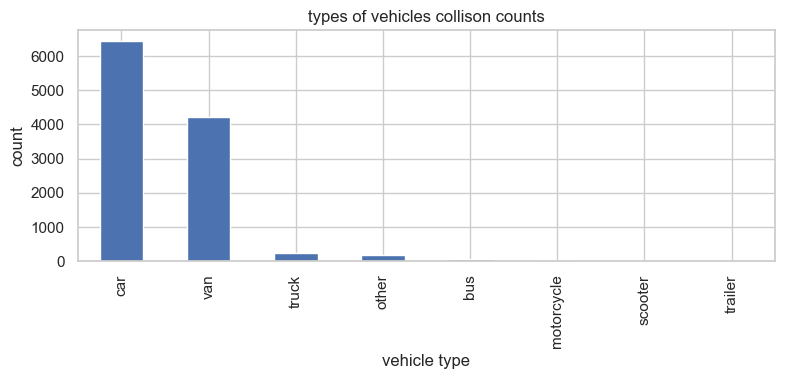

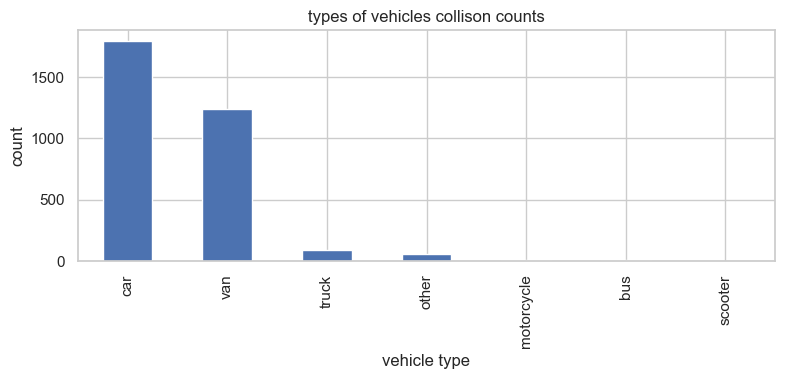

In [13]:
# plot types of vehicles
for i in types_of_vehicles:
    plt.figure(figsize=(9,3))
    train[i].value_counts()[~train[i].value_counts().index.isin(["unknown"])].plot.bar() # remove unkowns
    plt.title("types of vehicles collison counts")
    plt.xlabel("vehicle type")
    plt.ylabel("count")
    # save the generated visual to folder
    explore_.save_visuals(fig= plt.gcf(), viz_name= "types_of_vehicles_collison_counts", folder_name= 1)
    plt.show()

- car (suden or suv), and van have the most crashes

#### How many fatalities are there in the dataset?

0    809817
1       967
Name: fatality, dtype: int64


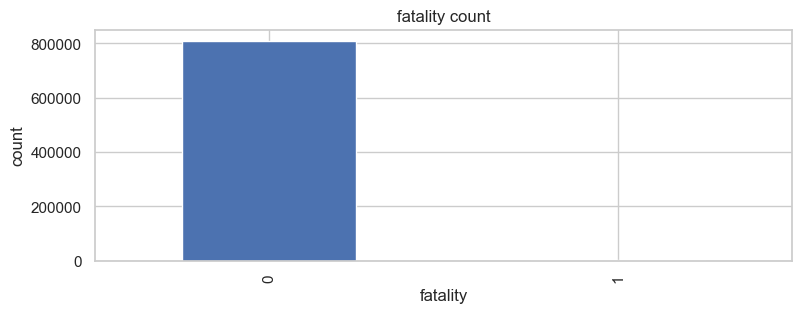

In [14]:
print(train.fatality.value_counts())
# Plot borough counts
plt.figure(figsize=(9,3))
train.fatality.value_counts().plot.bar()
plt.title("fatality count")
plt.xlabel("fatality")
plt.ylabel("count")
# save the generated visual to folder
explore_.save_visuals(fig= plt.gcf(), viz_name= "fatality_count", folder_name= 1)
plt.show()

- I see  967 fatalities in the training data

## Bivariate

#### Is there a relationship between the number of fatalities and the number of injured in crashes?

    - Null Hyp: There is no relationship between the number of fatalities and the number of injured in crashes.
    - Alt Hyp: There is a relationship between the number of fatalities and the number of injured in crashes.

In [15]:
# select only the injured columns
injured_cols = train.columns[train.columns.str.contains("injured")]
injured_cols

Index(['number_of_persons_injured', 'number_of_pedestrians_injured',
       'number_of_cyclist_injured', 'number_of_motorist_injured'],
      dtype='object')

In [16]:
# sum of all the injured columns
train["injured_sum"] = train[injured_cols].sum(axis=1)

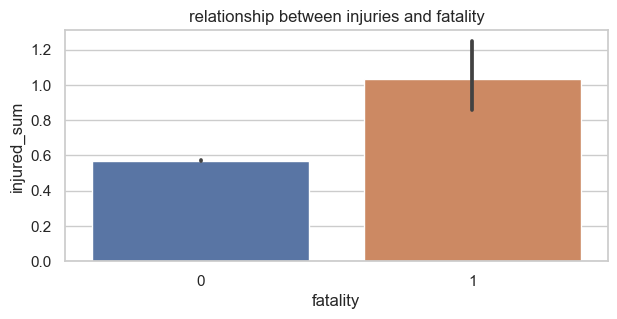

In [17]:
# plot relationship between injuries and fatality
plt.figure(figsize=(7,3))
sns.barplot(data=train, x="fatality", y="injured_sum")
plt.title("relationship between injuries and fatality")
# save the generated visual to folder
explore_.save_visuals(fig= plt.gcf(), viz_name= "injuries_and_fatality", folder_name= 2)
plt.show()

In [18]:
# set confidence level
alpha = 0.05

# create a cross tabulation
cont_table = pd.crosstab(train.fatality,train.injured_sum)
cont_table

injured_sum,0,1,2,3,4,5,6,7,8,9,...,30,32,34,36,44,46,48,54,68,86
fatality,,,,,,,,,,,,,,,,,,,,,
0,634149,2373,137679,93,23527,12,7513,2,2627,1,...,3,3,3,3,2,1,1,0,1,1
1,744,1,118,0,55,0,18,0,11,0,...,1,0,0,0,0,0,0,1,0,0


In [19]:
# create a chi2 contagency table
chi2, p_value, degrees_of_freedom, expected_pivot_table = stats.chi2_contingency(cont_table)

print("chi2",chi2)
print("p-value", p_value)

chi2 1491.2027812664846
p-value 4.0994723916890135e-296


In [20]:
def evaluate_null():
    if p_value < alpha:
        print("Reject null")
    else:
        print("Fail to reject null")
evaluate_null()

Reject null


- Data shows a relationship between the number of fatalities and the number of injured in crashes.

#### Do specific contributing factors have a higher association with fatalities?

* $H_o$ : Specific contributing factors don't a have higher association with fatalities?
* $H_a$ : Specific contributing factors have a higher association with fatalities?

In [21]:
# select only the contributing factor columns
contributing_factor = train.columns[train.columns.str.contains("factor")]
contributing_factor

Index(['contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'contributing_factor_vehicle_3', 'contributing_factor_vehicle_4',
       'contributing_factor_vehicle_5'],
      dtype='object')

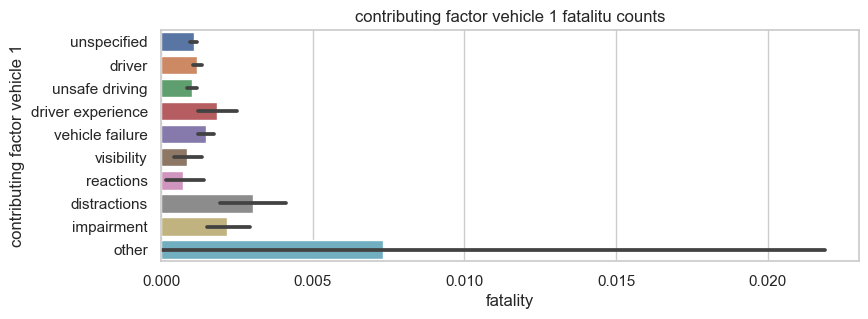

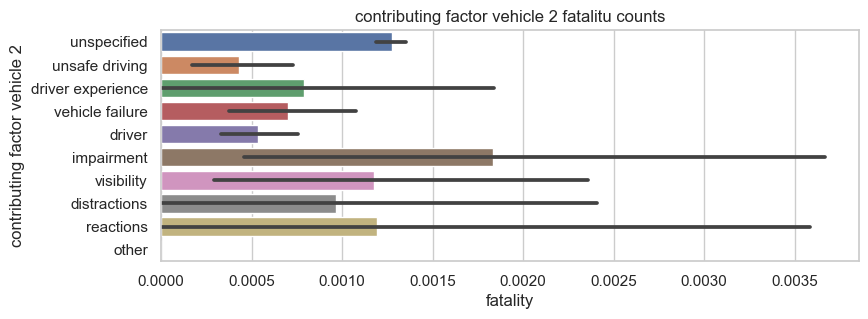

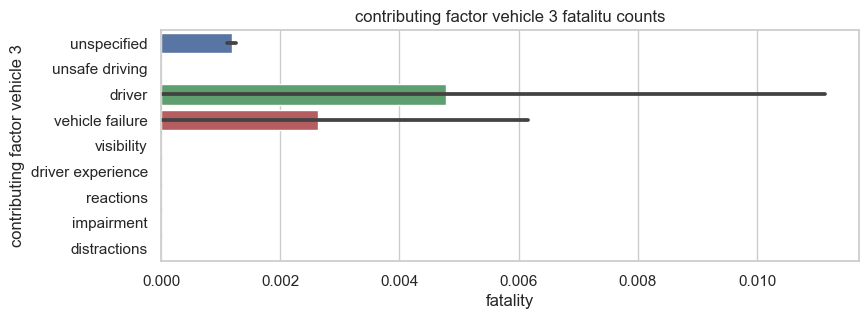

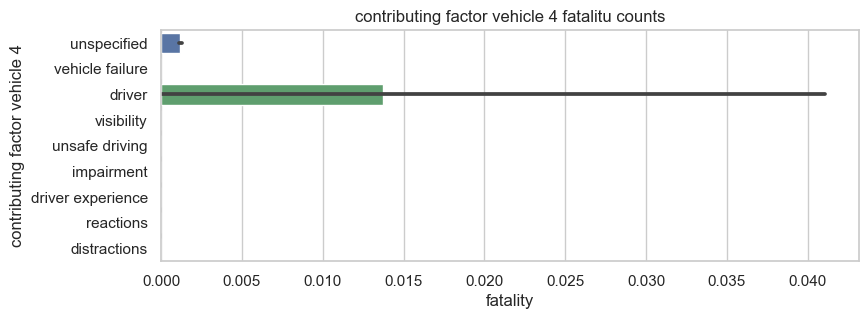

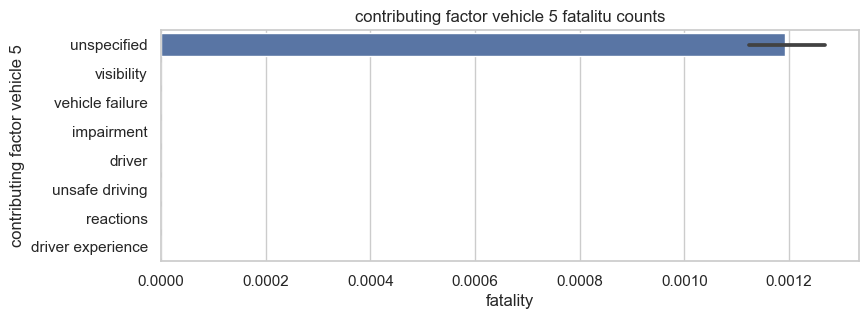

In [22]:
# plot the contributing factors with fatality
for i in contributing_factor:
    plt.figure(figsize=(9,3))
    sns.barplot(data=train, y=i, x="fatality")
    plt.title(f'{i.replace("_"," ")} fatalitu counts')
    plt.ylabel(f'{i.replace("_"," ")}')
    # save the generated visual to folder
    explore_.save_visuals(fig= plt.gcf(), viz_name= f"{i}_and_fatality", folder_name= 2)
    plt.show()


In [23]:
# add all the different cross tabs into a dictionary
factors_cross_tables = {}
for i in contributing_factor:
    factors_cross_tables[i] = pd.crosstab(train[i], train.fatality)

In [24]:
# assign contributing factos to there respective cross tables
contributing_factor = factors_cross_tables.keys()
contributing_factor

dict_keys(['contributing_factor_vehicle_1', 'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3', 'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5'])

In [25]:
alpha = 0.05

for ele in contributing_factor:
    # create a chi2 contagency table
    chi2, p_value, degrees_of_freedom, expected_pivot_table = stats.chi2_contingency(factors_cross_tables[ele])

    print(ele,"\n", "_"*30, "\nchi2",chi2, "\np-value", p_value)
    evaluate_null()
    print("\n\n")

contributing_factor_vehicle_1 
 ______________________________ 
chi2 67.9802808034536 
p-value 3.784681029130132e-11
Reject null



contributing_factor_vehicle_2 
 ______________________________ 
chi2 37.698330266275114 
p-value 1.9742768677930384e-05
Reject null



contributing_factor_vehicle_3 
 ______________________________ 
chi2 9.363621500245243 
p-value 0.3125556717840376
Fail to reject null



contributing_factor_vehicle_4 
 ______________________________ 
chi2 9.93315926890156 
p-value 0.26974865350580685
Fail to reject null



contributing_factor_vehicle_5 
 ______________________________ 
chi2 0.1230076111924626 
p-value 0.999995271062504
Fail to reject null





- Reject Null. Contributing_factor_vehicle_1 and contributing_factor_vehicle_2 have a higher association with fatality than 3,4 and 5

#### Are certain vehicle types more prone to be involved in fatal crashes?

* $H_0$ : Certain vehicle types are noy more prone to be involved in fatal crashes?
* $H_a$ : Certain vehicle types are more prone to be involved in fatal crashes

In [26]:
# select only the types of vehicles columns
types_of_vehicles = train.columns[train.columns.str.contains("type")]
types_of_vehicles

Index(['vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3',
       'vehicle_type_code_4', 'vehicle_type_code_5'],
      dtype='object')

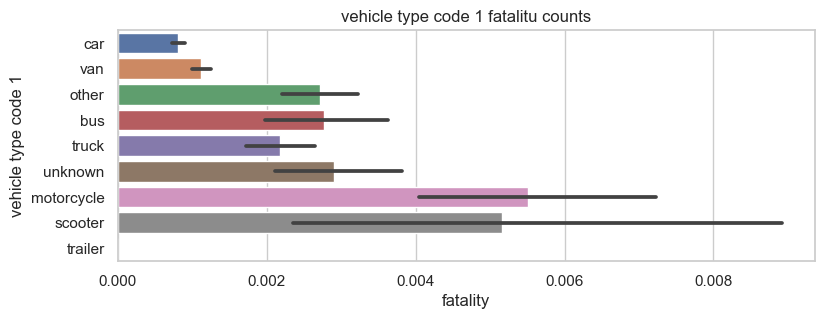

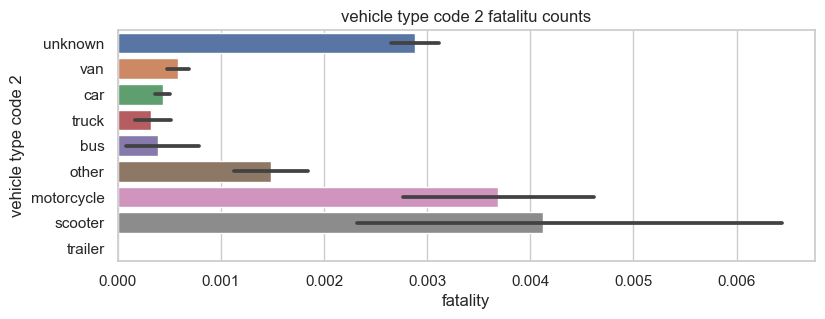

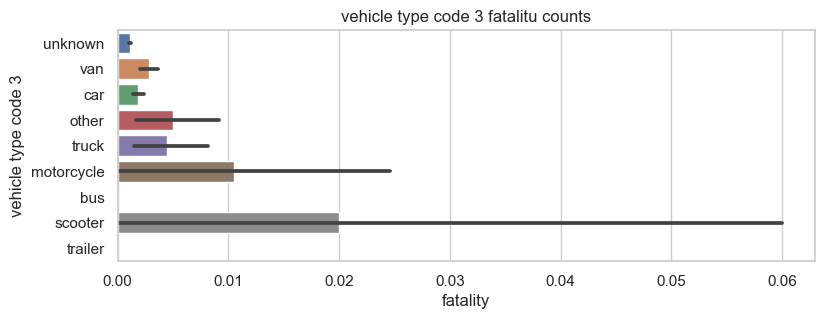

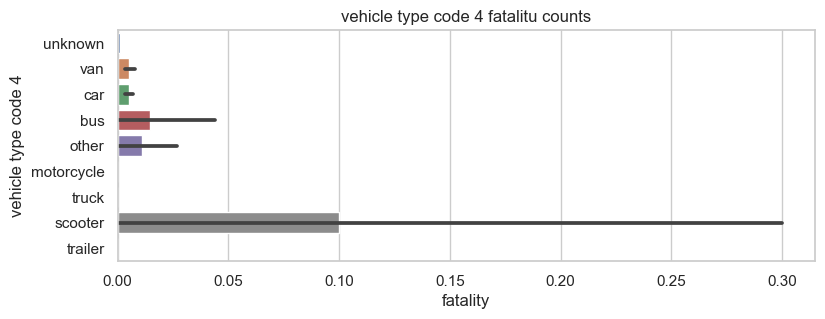

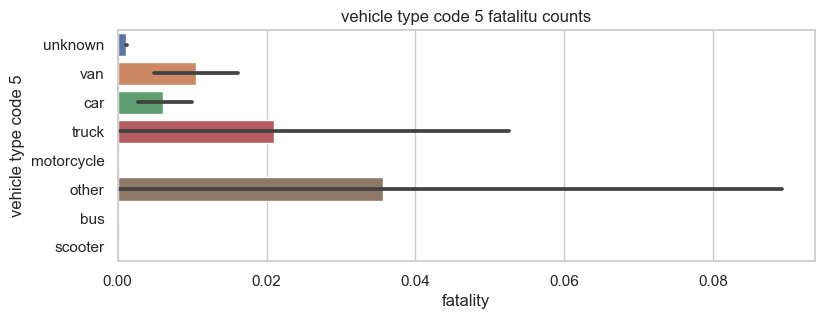

In [27]:
# plot the contributing factors with fatality
for i in types_of_vehicles:
    plt.figure(figsize=(9,3))
    sns.barplot(data=train, y=i, x="fatality")
    plt.title(f'{i.replace("_"," ")} fatalitu counts')
    plt.ylabel(f'{i.replace("_"," ")}')
    # save the generated visual to folder
    explore_.save_visuals(fig= plt.gcf(), viz_name= f"{i}_and_fatality", folder_name= 2)
    plt.show()


In [28]:
# add all the different cross tabs into a dictionary
vehicle_cross_tables = {}
for i in types_of_vehicles:
    vehicle_cross_tables[i] = pd.crosstab(train[i], train.fatality)

In [29]:
# assign contributing factos to there respective cross tables
types_of_vehicles = vehicle_cross_tables.keys()
types_of_vehicles

dict_keys(['vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5'])

In [30]:
alpha = 0.05

for ele in types_of_vehicles:
    # create a chi2 contagency table
    chi2, p_value, degrees_of_freedom, expected_pivot_table = stats.chi2_contingency(vehicle_cross_tables[ele])

    print(ele,"\n", "_"*30, "\nchi2",chi2, "\np-value", p_value)
    evaluate_null()
    print("\n\n")

vehicle_type_code_1 
 ______________________________ 
chi2 378.52061333877646 
p-value 7.332002661501408e-77
Reject null



vehicle_type_code_2 
 ______________________________ 
chi2 827.1083060413931 
p-value 2.9533405528835216e-173
Reject null



vehicle_type_code_3 
 ______________________________ 
chi2 116.7963810171884 
p-value 1.5189020580053491e-21
Reject null



vehicle_type_code_4 
 ______________________________ 
chi2 243.75219117859945 
p-value 3.6326363147615344e-48
Reject null



vehicle_type_code_5 
 ______________________________ 
chi2 214.61873835948407 
p-value 9.147271894810247e-43
Reject null





- Reject Null. Certain vehicle types are more prone to be involved in fatal crashes

#### Is there significant difference in the number of fatalities between different boroughs or zip codes?

In [110]:
# group by fatality borough groups
fatality_zipcode = train.groupby(["borough","zip_code", "fatality"])["fatality"].agg(["count"]).reset_index()
fatality_zipcode = fatality_zipcode[(fatality_zipcode.fatality == 1)].sort_values(by="count", ascending =False)
fatality_zipcode = fatality_zipcode.groupby(["borough"])["count"].agg(["count"]).reset_index()
fatality_zipcode

,borough,count
0,bronx,45
1,brooklyn,71
2,manhattan,53
3,queens,99
4,staten island,18


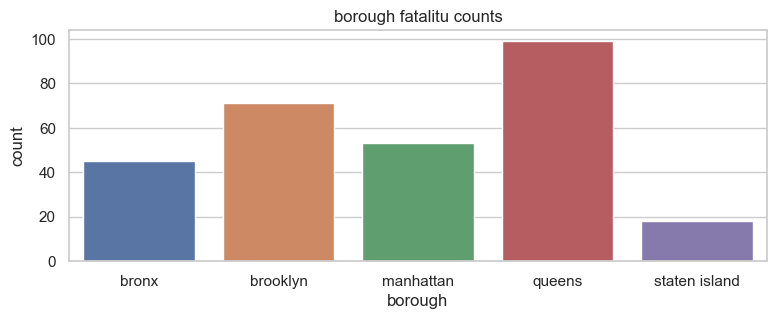

In [111]:
# plot the contributing factors with fatality
plt.figure(figsize=(9,3))
sns.barplot(data=fatality_zipcode, y="count", x="borough")
plt.title('borough fatalitu counts')
plt.ylabel('count')
# save the generated visual to folder
explore_.save_visuals(fig= plt.gcf(), viz_name= "borough_and_fatality", folder_name= 2)
plt.show()


**Take aways**

**Univariate**

- Sesonal trend found in number of motorists, cyclists, and personel ingired. look to not have a strong seasonal trend in the number of pedestrins ingired and in fatalities.

- Brooklyn has the highest number of collisons (250,000) and staten island has the lowest count (about 30,000).

- zipcode 11207 has the highest number of collisons.

- The most common contributing factors for crashes are driver distraction, unface driving, and vehicle failure.

- car (suden or suv), and van have the most crashes

- I see  967 fatalities in the training data

**Bivariate**

- Data shows a relationship between the number of fatalities and the number of injured in crashes.

- Reject Null. Certain vehicle types are more prone to be involved in fatal crashes